In [16]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import textstat
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
print("✓ All packages imported successfully")

✓ All packages imported successfully


In [17]:
#Load cleaned_base.csv
df = pd.read_csv('virality/data/processed/cleaned_base.csv')

print(f"Loaded {len(df)} articles with {len(df.columns)} columns")
print(f"\nFirst 5 column names: {list(df.columns[:5])}")
print(f"\nDataset shape: {df.shape}")

Loaded 39644 articles with 63 columns

First 5 column names: ['url', ' timedelta', ' n_tokens_title', ' n_tokens_content', ' n_unique_tokens']

Dataset shape: (39644, 63)


In [18]:
# Fix viral threshold to 1400 shares
VIRAL_THRESHOLD = 1400

# Check current distribution
print("Current viral distribution:")
print(df['viral'].value_counts(normalize=True))

# Recreate with 1400 threshold
df['viral'] = (df[' shares'] >= VIRAL_THRESHOLD).astype(int)

print(f"\nNew viral distribution (threshold={VIRAL_THRESHOLD}):")
viral_counts = df['viral'].value_counts()
print(f"Not Viral (0): {viral_counts[0]} ({viral_counts[0]/len(df)*100:.1f}%)")
print(f"Viral (1): {viral_counts[1]} ({viral_counts[1]/len(df)*100:.1f}%)")
print("\n✓ Threshold fixed - now balanced!")

Current viral distribution:
viral
0    0.89837
1    0.10163
Name: proportion, dtype: float64

New viral distribution (threshold=1400):
Not Viral (0): 18490 (46.6%)
Viral (1): 21154 (53.4%)

✓ Threshold fixed - now balanced!


In [19]:
# Fix column names (strip leading spaces)
print("Fixing column names...")
df.columns = df.columns.str.strip()

print("✓ Column names cleaned")
print(f"First 5 columns now: {list(df.columns[:5])}")

# Verify no more spaces
space_cols = [col for col in df.columns if col.startswith(' ')]
print(f"Columns with spaces remaining: {len(space_cols)}")

Fixing column names...
✓ Column names cleaned
First 5 columns now: ['url', 'timedelta', 'n_tokens_title', 'n_tokens_content', 'n_unique_tokens']
Columns with spaces remaining: 0


In [20]:
# Create basic engineered features

print("Creating basic features...")

# Text Features
df['headline_word_count'] = df['n_tokens_title']
df['article_word_count'] = df['n_tokens_content']

#Keyword Features
df['keyword_count'] = df['num_keywords']
df['keyword_density'] = (df['num_keywords'] / (df['n_tokens_content'] + 1)) * 100
df['keyword_quality'] = df['kw_avg_avg']

#Timing Features 
weekday_cols = ['weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday',
                'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday', 
                'weekday_is_sunday']

df['weekday'] = df[weekday_cols].idxmax(axis=1).str.replace('weekday_is_', '')

# Weekend and week parts
df['early_week'] = ((df['weekday_is_monday'] == 1) | (df['weekday_is_tuesday'] == 1)).astype(int)
df['mid_week'] = ((df['weekday_is_wednesday'] == 1) | (df['weekday_is_thursday'] == 1)).astype(int)
df['late_week'] = (df['weekday_is_friday'] == 1).astype(int)

print("✓ Textual, keyword, and timing features created")
print(f"Dataset now has {len(df.columns)} columns")

Creating basic features...
✓ Textual, keyword, and timing features created
Dataset now has 72 columns


In [21]:
#Engagement and sentiment features

#Engagement Features
df['content_richness'] = df['num_imgs'] + df['num_videos'] + (df['num_hrefs'] / 5)
df['has_video'] = (df['num_videos'] > 0).astype(int)
df['has_images'] = (df['num_imgs'] > 0).astype(int)
df['self_ref_ratio'] = df['num_self_hrefs'] / (df['num_hrefs'] + 1)

#Sentiment Interaction Features
df['pos_neg_ratio'] = df['rate_positive_words'] / (df['rate_negative_words'] + 0.01)
df['positive_strength'] = df['global_rate_positive_words'] * df['avg_positive_polarity']
df['negative_strength'] = df['global_rate_negative_words'] * abs(df['avg_negative_polarity'])
df['sentiment_balance'] = df['positive_strength'] - df['negative_strength']
df['title_content_sentiment_gap'] = abs(df['title_sentiment_polarity'] - df['global_sentiment_polarity'])

print("✓ Engagement and sentiment features created")
print(f"Dataset now has {len(df.columns)} columns")

✓ Engagement and sentiment features created
Dataset now has 81 columns


In [22]:
# Extract headline text from URLs

def extract_headline_from_url(url):
    """Extract headline text from Mashable URL"""
    try:
        slug = url.rstrip('/').split('/')[-1]
        headline = slug.replace('-', ' ')
        return headline
    except:
        return ""

print("Extracting headlines from URLs...")
df['headline_text'] = df['url'].apply(extract_headline_from_url)

print("✓ Headlines extracted")
print("\nExample headlines:")
for i in range(3):
    print(f"  URL: {df['url'].iloc[i]}")
    print(f"  Headline: {df['headline_text'].iloc[i]}\n")

Extracting headlines from URLs...
✓ Headlines extracted

Example headlines:
  URL: http://mashable.com/2013/01/07/amazon-instant-video-browser/
  Headline: amazon instant video browser

  URL: http://mashable.com/2013/01/07/ap-samsung-sponsored-tweets/
  Headline: ap samsung sponsored tweets

  URL: http://mashable.com/2013/01/07/apple-40-billion-app-downloads/
  Headline: apple 40 billion app downloads



Running VADER sentiment analysis...
(This takes about 30-60 seconds for 40k articles)
✓ VADER sentiment scores created

VADER compound score distribution:
count    39644.000000
mean        -0.000090
std          0.238701
min         -0.953800
25%          0.000000
50%          0.000000
75%          0.000000
max          0.908000
Name: vader_compound, dtype: float64


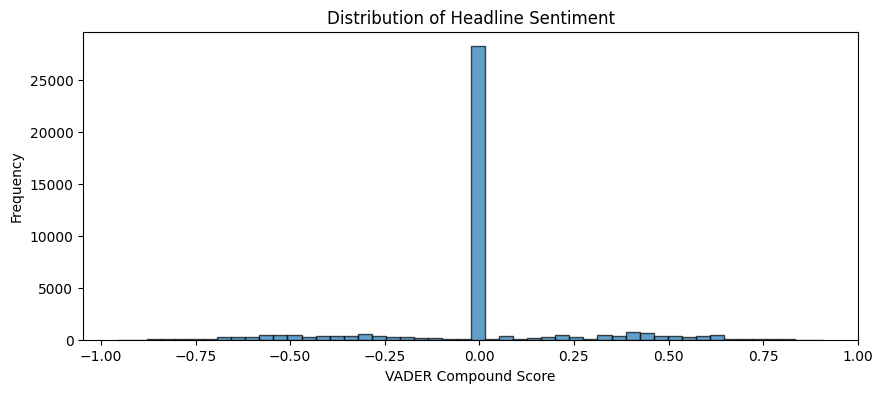

In [23]:
#VADER sentiment analysis on headlines

analyzer = SentimentIntensityAnalyzer()

def get_vader_scores(text):
    if pd.isna(text) or text == "":
        return {'neg': 0, 'neu': 0, 'pos': 0, 'compound': 0}
    return analyzer.polarity_scores(text)

print("Running VADER sentiment analysis...")
print("(This takes about 30-60 seconds for 40k articles)")

vader_scores = df['headline_text'].apply(get_vader_scores)

df['vader_negative'] = vader_scores.apply(lambda x: x['neg'])
df['vader_neutral'] = vader_scores.apply(lambda x: x['neu'])
df['vader_positive'] = vader_scores.apply(lambda x: x['pos'])
df['vader_compound'] = vader_scores.apply(lambda x: x['compound'])

print("✓ VADER sentiment scores created")
print(f"\nVADER compound score distribution:")
print(df['vader_compound'].describe())

# Quick visualization
plt.figure(figsize=(10, 4))
plt.hist(df['vader_compound'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('VADER Compound Score')
plt.ylabel('Frequency')
plt.title('Distribution of Headline Sentiment')
plt.show()

In [24]:
# Readability scores

def get_readability_scores(text):
    if pd.isna(text) or text == "" or len(text.split()) < 2:
        return {'flesch_reading_ease': 0, 'flesch_kincaid_grade': 0}
    try:
        fre = textstat.flesch_reading_ease(text)
        fkg = textstat.flesch_kincaid_grade(text)
        return {'flesch_reading_ease': fre, 'flesch_kincaid_grade': fkg}
    except:
        return {'flesch_reading_ease': 0, 'flesch_kincaid_grade': 0}

print("Calculating readability scores...")
readability = df['headline_text'].apply(get_readability_scores)

df['flesch_reading_ease'] = readability.apply(lambda x: x['flesch_reading_ease'])
df['flesch_kincaid_grade'] = readability.apply(lambda x: x['flesch_kincaid_grade'])

print("✓ Readability scores created")
print(f"\nFlesch Reading Ease stats:")
print(df['flesch_reading_ease'].describe())

Calculating readability scores...
✓ Readability scores created

Flesch Reading Ease stats:
count    39644.000000
mean        49.452361
std         41.082698
min       -219.210000
25%         32.560000
50%         54.725000
75%         77.905000
max        120.205000
Name: flesch_reading_ease, dtype: float64


In [25]:
#TF-IDF vectorization + PCA

print("Creating TF-IDF vectors...")
print("(This takes 1-2 minutes for 40k articles)")

tfidf = TfidfVectorizer(
    max_features=500,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=5
)

headline_tfidf = tfidf.fit_transform(df['headline_text'].fillna(''))
print(f"✓ TF-IDF matrix created: {headline_tfidf.shape}")

print("\nApplying PCA to reduce to 30 components...")
N_COMPONENTS = 30
pca = PCA(n_components=N_COMPONENTS, random_state=42)
headline_pca = pca.fit_transform(headline_tfidf.toarray())

# Create PCA columns
pca_columns = [f'headline_pc{i+1}' for i in range(N_COMPONENTS)]
pca_df = pd.DataFrame(headline_pca, columns=pca_columns, index=df.index)
df = pd.concat([df, pca_df], axis=1)

print(f"✓ PCA complete: {N_COMPONENTS} components created")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.1%}")
print(f"\nDataset now has {len(df.columns)} columns")

Creating TF-IDF vectors...
(This takes 1-2 minutes for 40k articles)
✓ TF-IDF matrix created: (39644, 500)

Applying PCA to reduce to 30 components...
✓ PCA complete: 30 components created
Total variance explained: 23.8%

Dataset now has 118 columns


In [26]:
# Save complete feature set

# Fill any remaining NaN values
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(0)

# Save
output_path = 'virality/data/processed/features_complete.csv'
df.to_csv(output_path, index=False)

print("\n" + "="*60)
print("FEATURE ENGINEERING COMPLETE! 🎉")
print("="*60)
print(f"Saved to: {output_path}")
print(f"\nFinal dataset statistics:")
print(f"  Total articles: {len(df):,}")
print(f"  Total features: {len(df.columns)}")
print(f"  Viral articles: {df['viral'].sum():,} ({df['viral'].mean()*100:.1f}%)")
print(f"  Non-viral articles: {(~df['viral'].astype(bool)).sum():,} ({(1-df['viral'].mean())*100:.1f}%)")
print(f"\n✓ Ready for modeling!")
print(f"✓ Your teammates can now use 'features_complete.csv'")


FEATURE ENGINEERING COMPLETE! 🎉
Saved to: virality/data/processed/features_complete.csv

Final dataset statistics:
  Total articles: 39,644
  Total features: 118
  Viral articles: 21,154 (53.4%)
  Non-viral articles: 18,490 (46.6%)

✓ Ready for modeling!
✓ Your teammates can now use 'features_complete.csv'


In [27]:
# Summary of new features created

new_features_summary = {
    'Basic Features': ['headline_word_count', 'article_word_count', 'keyword_count', 
                      'keyword_density', 'keyword_quality'],
    'Timing': ['weekday', 'early_week', 'mid_week', 'late_week'],
    'Engagement': ['content_richness', 'has_video', 'has_images', 'self_ref_ratio'],
    'Sentiment': ['pos_neg_ratio', 'positive_strength', 'negative_strength', 
                 'sentiment_balance', 'title_content_sentiment_gap'],
    'Text - VADER': ['vader_negative', 'vader_neutral', 'vader_positive', 'vader_compound'],
    'Text - Readability': ['flesch_reading_ease', 'flesch_kincaid_grade'],
    'Text - PCA': [f'headline_pc{i}' for i in range(1, 31)]
}

print("New Features:")
total = 0
for category, features in new_features_summary.items():
    print(f"\n{category}: {len(features)} features")
    total += len(features)
    if len(features) <= 10:  
        for feat in features:
            print(f"  - {feat}")
    else:
        print(f"  - {features[0]} through {features[-1]}")

print(f"\n{'='*60}")
print(f"TOTAL NEW FEATURES: {total}")
print(f"ORIGINAL FEATURES: 61")
print(f"FINAL FEATURE COUNT: ~{61 + total}")

New Features:

Basic Features: 5 features
  - headline_word_count
  - article_word_count
  - keyword_count
  - keyword_density
  - keyword_quality

Timing: 4 features
  - weekday
  - early_week
  - mid_week
  - late_week

Engagement: 4 features
  - content_richness
  - has_video
  - has_images
  - self_ref_ratio

Sentiment: 5 features
  - pos_neg_ratio
  - positive_strength
  - negative_strength
  - sentiment_balance
  - title_content_sentiment_gap

Text - VADER: 4 features
  - vader_negative
  - vader_neutral
  - vader_positive
  - vader_compound

Text - Readability: 2 features
  - flesch_reading_ease
  - flesch_kincaid_grade

Text - PCA: 30 features
  - headline_pc1 through headline_pc30

TOTAL NEW FEATURES: 54
ORIGINAL FEATURES: 61
FINAL FEATURE COUNT: ~115
